This notebook evaluates performance gains of `CudaCosineGreedy` against `matchms`.

Performance depends heavily on used hardware, as well as how correlated the spectra are with each other, (i.e. on average, how many common pairs of peaks do spectra have). 

This specific notebook evaulates the performance given the following below arguments (feel free to change these):

In [25]:
# We compare pairwise similarity performance on `spectra_file`
spectra_file = 'GNPS-LIBRARY.mgf'
# We take a random sample of spectra from said file
# Minimum size (as a power of two):
chunk_sizes_min = 2
# Maximum size (as a power of two):
chunk_sizes_max = 14

# max number of peaks to retain in any spectra - larger numbers are marginally more accurate, but much slower
max_peaks = 1024

# optimal batch size is hardware-dependent, but usually the best number is the largest the hardware can handle (without an OOM error)
batch_size = 2048

# Hardware matters! These results are only repeatable using this GPU (shown as an output)
! nvidia-smi -L
! echo Number of CPU cores $(nproc)

GPU 0: NVIDIA GeForce RTX 2070 with Max-Q Design (UUID: GPU-f6e241c8-f0ad-720e-be22-2713a6b0868d)
Number of CPU cores 12


In [4]:
%load_ext autoreload
%autoreload 2
%env PYTHONWARNINGS ignore
! pip uninstall cudams -q -y
! pip install -q --upgrade git+https://github.com/tornikeo/cosine-similarity@main

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
env: PYTHONWARNINGS=ignore


In [5]:
from cudams.utils import argbatch, Timer
from cudams.similarity.kernels import compile_cuda_cosine_greedy_kernel
from pathlib import Path
from tqdm import tqdm
from numba import cuda
import numpy as np
import matplotlib.pyplot as plt

assert cuda.is_available()

In [10]:
from cudams.utils import download
from joblib import Parallel, delayed
from matchms.filtering import default_filters, normalize_intensities, reduce_to_number_of_peaks
from matchms.importing import load_from_mgf
from cudams.utils import mute_stdout

with mute_stdout():
    fpath = download(spectra_file)
    def parse_spectrum(spectrum):
        spectrum = default_filters(spectrum)
        spectrum = reduce_to_number_of_peaks(spectrum, n_max=max_peaks)
        spectrum = normalize_intensities(spectrum)
        return spectrum

    spectra = Parallel(-2)(delayed(parse_spectrum)(spec) 
                            for spec in tqdm(load_from_mgf(fpath)))
    spectra = [spe for spe in spectra if spe is not None]

1694it [00:01, 1345.62it/s]

2024-03-01 14:25:04,982:WARNING:matchms:correct_charge:Changed sign of given charge: -1 to match positive ionmode
2024-03-01 14:25:04,987:WARNING:matchms:correct_charge:Changed sign of given charge: -1 to match positive ionmode
2024-03-01 14:25:04,992:WARNING:matchms:correct_charge:Changed sign of given charge: -1 to match positive ionmode


3522it [00:03, 574.97it/s] 

2024-03-01 14:25:07,084:WARNING:matchms:interpret_unknown_adduct:Charge was found 0 times in adduct [M+Fe-2H]
2024-03-01 14:25:07,107:WARNING:matchms:interpret_unknown_adduct:Charge was found 0 times in adduct [M+Fe-2H]
2024-03-01 14:25:07,118:WARNING:matchms:interpret_unknown_adduct:Charge was found 0 times in adduct [M+Fe-2H]
2024-03-01 14:25:07,123:WARNING:matchms:interpret_unknown_adduct:Charge was found 0 times in adduct [M+Fe-2H]
2024-03-01 14:25:07,133:WARNING:matchms:interpret_unknown_adduct:Charge was found 0 times in adduct [M+Fe-2H]
2024-03-01 14:25:07,143:WARNING:matchms:interpret_unknown_adduct:Charge was found 0 times in adduct [M+Fe-2H]
2024-03-01 14:25:07,148:WARNING:matchms:interpret_unknown_adduct:Charge was found 0 times in adduct [M+Fe-2H]
2024-03-01 14:25:07,158:WARNING:matchms:interpret_unknown_adduct:Charge was found 0 times in adduct [M+Fe-2H]
2024-03-01 14:25:07,168:WARNING:matchms:interpret_unknown_adduct:Charge was found 0 times in adduct [M+Fe-2H]
2024-03-01

4118it [00:04, 1032.40it/s]

2024-03-01 14:25:07,577:WARNING:matchms:derive_adduct_from_name:Two potential adducts were found in the compound name that are both valid adducts. The first adduct is used. The adducts found are: ['[2M+H]+', '[M+H]+']


4398it [00:04, 1192.72it/s]

2024-03-01 14:25:07,819:WARNING:matchms:interpret_unknown_adduct:Charge was found 0 times in adduct [M+Na+]


4554it [00:04, 1181.06it/s]

2024-03-01 14:25:08,041:WARNING:matchms:interpret_unknown_adduct:Charge was found 0 times in adduct [M+H+]
2024-03-01 14:25:08,045:WARNING:matchms:interpret_unknown_adduct:Charge was found 0 times in adduct [M+Na+]


4906it [00:04, 1084.32it/s]

2024-03-01 14:25:08,154:WARNING:matchms:interpret_unknown_adduct:Charge was found 0 times in adduct [M+H+]
2024-03-01 14:25:08,159:WARNING:matchms:interpret_unknown_adduct:Charge was found 0 times in adduct [M+Na+]


5172it [00:05, 1162.60it/s]

2024-03-01 14:25:08,522:WARNING:matchms:interpret_unknown_adduct:Charge was found 0 times in adduct [M+NH4;]
2024-03-01 14:25:08,544:WARNING:matchms:interpret_unknown_adduct:Charge was found 0 times in adduct [M+H-CO]
2024-03-01 14:25:08,546:WARNING:matchms:interpret_unknown_adduct:Charge was found 0 times in adduct [M-CO+Hputative]
2024-03-01 14:25:08,559:WARNING:matchms:interpret_unknown_adduct:Charge was found 0 times in adduct [M-CO+H]
2024-03-01 14:25:08,729:WARNING:matchms:interpret_unknown_adduct:Charge was found 0 times in adduct [M-3H+Fe+Na]


5593it [00:05, 1290.86it/s]

2024-03-01 14:25:08,771:WARNING:matchms:interpret_unknown_adduct:Charge was found 0 times in adduct [M-H2
2024-03-01 14:25:08,791:WARNING:matchms:interpret_unknown_adduct:Charge was found 0 times in adduct [M-H2+Fe]
2024-03-01 14:25:08,801:WARNING:matchms:interpret_unknown_adduct:Charge was found 0 times in adduct [M-H2+Fe]
2024-03-01 14:25:08,810:WARNING:matchms:interpret_unknown_adduct:Charge was found 0 times in adduct [M-H2+Fe]
2024-03-01 14:25:08,815:WARNING:matchms:interpret_unknown_adduct:Charge was found 0 times in adduct [M-H2+Fe]
2024-03-01 14:25:08,820:WARNING:matchms:interpret_unknown_adduct:Charge was found 0 times in adduct [M-H2+Fe]
2024-03-01 14:25:08,825:WARNING:matchms:interpret_unknown_adduct:Charge was found 0 times in adduct [M-H2+Fe]
2024-03-01 14:25:08,856:WARNING:matchms:interpret_unknown_adduct:Charge was found 0 times in adduct [M-3H+Fe+Na]


6445it [00:06, 916.75it/s] 

2024-03-01 14:25:09,771:WARNING:matchms:correct_charge:Changed sign of given charge: -1 to match positive ionmode
2024-03-01 14:25:09,775:WARNING:matchms:correct_charge:Changed sign of given charge: -1 to match positive ionmode


7769it [00:07, 1234.50it/s]

2024-03-01 14:25:10,915:WARNING:matchms:derive_adduct_from_name:Two potential adducts were found in the compound name that are both valid adducts. The first adduct is used. The adducts found are: ['[M+H]+', '[M+Al]+']


11870it [00:11, 1150.92it/s]

2024-03-01 14:25:15,066:WARNING:matchms:derive_adduct_from_name:Two potential adducts were found in the compound name that are both valid adducts. The first adduct is used. The adducts found are: ['[M+H]+', '[M+Na]+']
2024-03-01 14:25:15,070:WARNING:matchms:derive_adduct_from_name:Two potential adducts were found in the compound name that are both valid adducts. The first adduct is used. The adducts found are: ['[M+H]+', '[M+Na]+']


12108it [00:11, 946.33it/s] 

2024-03-01 14:25:15,343:WARNING:matchms:correct_charge:Changed sign of given charge: -1 to match positive ionmode
2024-03-01 14:25:15,359:WARNING:matchms:correct_charge:Changed sign of given charge: -1 to match positive ionmode
2024-03-01 14:25:15,388:WARNING:matchms:interpret_unknown_adduct:Charge was found 0 times in adduct [M+2H+]


13559it [00:13, 817.64it/s] 

2024-03-01 14:25:16,730:WARNING:matchms:correct_charge:Changed sign of given charge: -1 to match positive ionmode


14244it [00:14, 997.54it/s]


Estimate total runtime of matchms using linear interpolation

In [21]:
from matchms.similarity import CosineGreedy
from matchms import calculate_scores
from cudams.utils import Timer

np.random.seed(42)
chunk_sizes = 2 ** np.arange(chunk_sizes_min, chunk_sizes_max, dtype=int)
times = []
pairs = []
kernel = CosineGreedy()
for chunk_size in tqdm(chunk_sizes):
    references = np.random.choice(spectra, size=chunk_size, replace=False)
    queries = references
    with Timer() as timer:
        kernel.matrix(references, queries, is_symmetric=True)
    times.append(timer.duration)
    pairs.append(len(references) * len(queries) / 2) # Div by 2 because it's symmetric

100%|██████████| 9/9 [04:01<00:00, 26.83s/it]


In [24]:
from cudams.similarity import CudaCosineGreedy

np.random.seed(42)

times_cu = []
pairs_cu = []

# Kernel compilation might take a bit of time initially
kernel = CudaCosineGreedy(batch_size=batch_size)

# To force CUDA to load code to GPU, we need to do warmup
kernel.matrix(spectra[:64], spectra[:64])

for chunk_size in tqdm(chunk_sizes):
    chunk_size = min(len(spectra), chunk_size) # We might run out of spectra
    # Don't do symmetric, as it's not implemented (or necessary)
    references = np.random.choice(spectra, size=chunk_size, replace=False)
    queries = np.random.choice(spectra, size=chunk_size, replace=False)
    with Timer() as timer:
        kernel.matrix(references, queries)
    times_cu.append(timer.duration)
    pairs_cu.append(len(references) * len(queries)) # We've processed all pairs

 55%|█████▍    | 6/11 [00:07<00:06,  1.30s/it]


KeyboardInterrupt: 

In [26]:
from cudams.similarity import CudaCosineGreedy

np.random.seed(42)
chunk_sizes_cu = 2 ** np.arange(2, 13, dtype=int)
times_cu_sparse = []
pairs_cu_sparse = []

# Kernel compilation might take a bit of time initially
kernel = CudaCosineGreedy(batch_size=batch_size)

# To force CUDA to load code to GPU, we need to do warmup
kernel.matrix(spectra[:64], spectra[:64], array_type='sparse')

for chunk_size in tqdm(chunk_sizes):
    chunk_size = min(len(spectra), chunk_size) # We might run out of spectra
    # Don't do symmetric, as it's not implemented (or necessary)
    references = np.random.choice(spectra, size=chunk_size, replace=False)
    queries = np.random.choice(spectra, size=chunk_size, replace=False)
    with Timer() as timer:
        kernel.matrix(references, queries, array_type='sparse')
    times_cu_sparse.append(timer.duration)
    pairs_cu_sparse.append(len(references) * len(queries)) # We've processed all pairs

 82%|████████▏ | 9/11 [00:41<00:21, 10.75s/it]

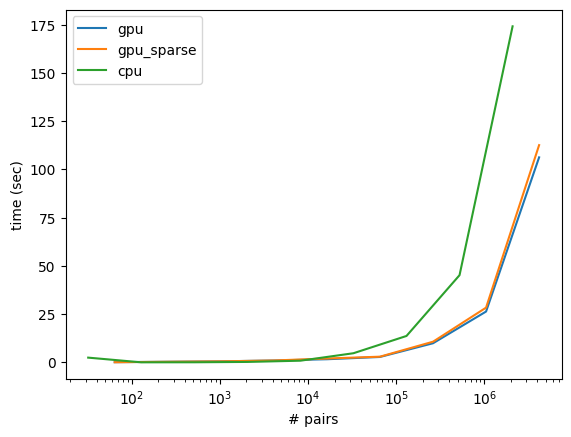

In [23]:
plt.semilogx(pairs_cu, times_cu, label='gpu')
plt.semilogx(pairs_cu_sparse, times_cu_sparse, label='gpu_sparse')
plt.semilogx(pairs, times, label='cpu')
plt.xlabel("# pairs")
plt.ylabel("time (sec)")
plt.legend()
plt.show()